In [ ]:
import PIL
from random import sample
from random import randint
from random import shuffle
from os.path import join
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir

from google.colab import drive
drive.mount("/content/drive")
%matplotlib inline

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Путь к маскам
PATH_TO_MASKS_CLEAN = '/content/drive/MyDrive/plates/masks/cleaned'
PATH_TO_MASKS_DIRTY = '/content/drive/MyDrive/plates/masks/dirty'
# Пути к обучающим данным
PATH_TO_TRAIN_CLEAN = '/content/drive/MyDrive/plates/plates/train/cleaned'
PATH_TO_TRAIN_DIRTY = '/content/drive/MyDrive/plates/plates/train/dirty'
# Путь к результатам аугментации
PATH_TO_AUG = '/content/drive/MyDrive/plates/augmented'
# Создаем папки для аугментированных данных
os.makedirs(join(PATH_TO_AUG, 'cleaned'), exist_ok=True)
os.makedirs(join(PATH_TO_AUG, 'dirty'), exist_ok=True)

In [ ]:
# количество аугментаций на одну фотографию
AUGMENTATIONS_COUNT = 10
# максимальный множитель для маски
AUGMENTATIONS_MULTIPLIER_MAX_VALUE = 40
# вероятность поменять каналы местами (в процентах)
P_OF_SHUFFLE = 30
# вероятность инвертировать каналы
P_OF_INVERTION = 40
# вероятность прибавки шума к слою с цветом
P_OF_CHANGING = 20
# модуль (p поля галуа) для операций сложения / умножения
MODULUS = 255

In [ ]:
labels = ['cleaned', 'dirty']

# Для любого изображения из папок dirty / cleaned создадим множество изображений - аналогов в папке augments/dirty or cleaned

In [ ]:
def transform(image: PIL.Image, mask: PIL.Image) -> PIL.Image:
  try:
      """Кастомные аугментации"""
      image_array = np.array(image, dtype=np.int16)
      mask_array = np.array(mask, dtype=np.int16)

      # Перестановка каналов
      if randint(0, 100) < P_OF_SHUFFLE:
          order = [0, 1, 2]
          shuffle(order)
          image_array = image_array[..., order]

      # Инверсия канала
      if randint(0, 100) < P_OF_INVERTION:
          channel = randint(0, 2)
          image_array[..., channel] = MODULUS - image_array[..., channel]

      # Обработка маской
      mask_active = mask_array > 20
      for channel in range(3):
          new_color = randint(-AUGMENTATIONS_MULTIPLIER_MAX_VALUE,
                            AUGMENTATIONS_MULTIPLIER_MAX_VALUE)

          if P_OF_CHANGING >= randint(0, 100):
              image_array[mask_active, channel] = new_color
          else:
              image_array[mask_active, channel] = (image_array[mask_active, channel] + new_color) % MODULUS

      return PIL.Image.fromarray(image_array.astype(np.uint8))
  except Exception as e:
    print(f"Ошибка в transform: {str(e)}")
    return image

In [ ]:
# Обработка данных
labels = ['cleaned', 'dirty']
train_paths = {
    'cleaned': PATH_TO_TRAIN_CLEAN,
    'dirty': PATH_TO_TRAIN_DIRTY
}
mask_paths = {
    'cleaned': PATH_TO_MASKS_CLEAN,
    'dirty': PATH_TO_MASKS_DIRTY
}

for label in labels:
    print(f"\nProcessing {label} images...")
    current_train_path = train_paths[label]
    current_mask_path = mask_paths[label]

    image_files = [f for f in listdir(current_train_path) if f.endswith(('.jpg', '.png'))]
    total_images = len(image_files)

    for idx, image_name in enumerate(image_files, 1):
        print(f'Processing: {image_name} ({idx}/{total_images})')

        # Загрузка изображения и маски
        image_path = join(current_train_path, image_name)
        mask_path = join(current_mask_path, image_name)

        if not os.path.exists(mask_path):
            print(f"Warning: Mask not found for {image_name}")
            continue

        try:
            image = PIL.Image.open(image_path)
            mask = PIL.Image.open(mask_path)

            # Аргументация
            for count in range(AUGMENTATIONS_COUNT):
                new_image = transform(image, mask)
                output_path = join(PATH_TO_AUG, label, f"{os.path.splitext(image_name)[0]}_{count}.jpg")
                new_image.save(output_path)

        except Exception as e:
            print(f"Error processing {image_name}: {str(e)}")

print("\nAugmentation completed successfully!")


Processing cleaned images...
Processing: 0002.jpg (1/20)
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Ошибка в transform: too many indices for array: array is 3-dimensional, but 4 were indexed
Processing: 0000.jpg (2/20)
Ошиб


Визуализация аугментированных изображений: cleaned


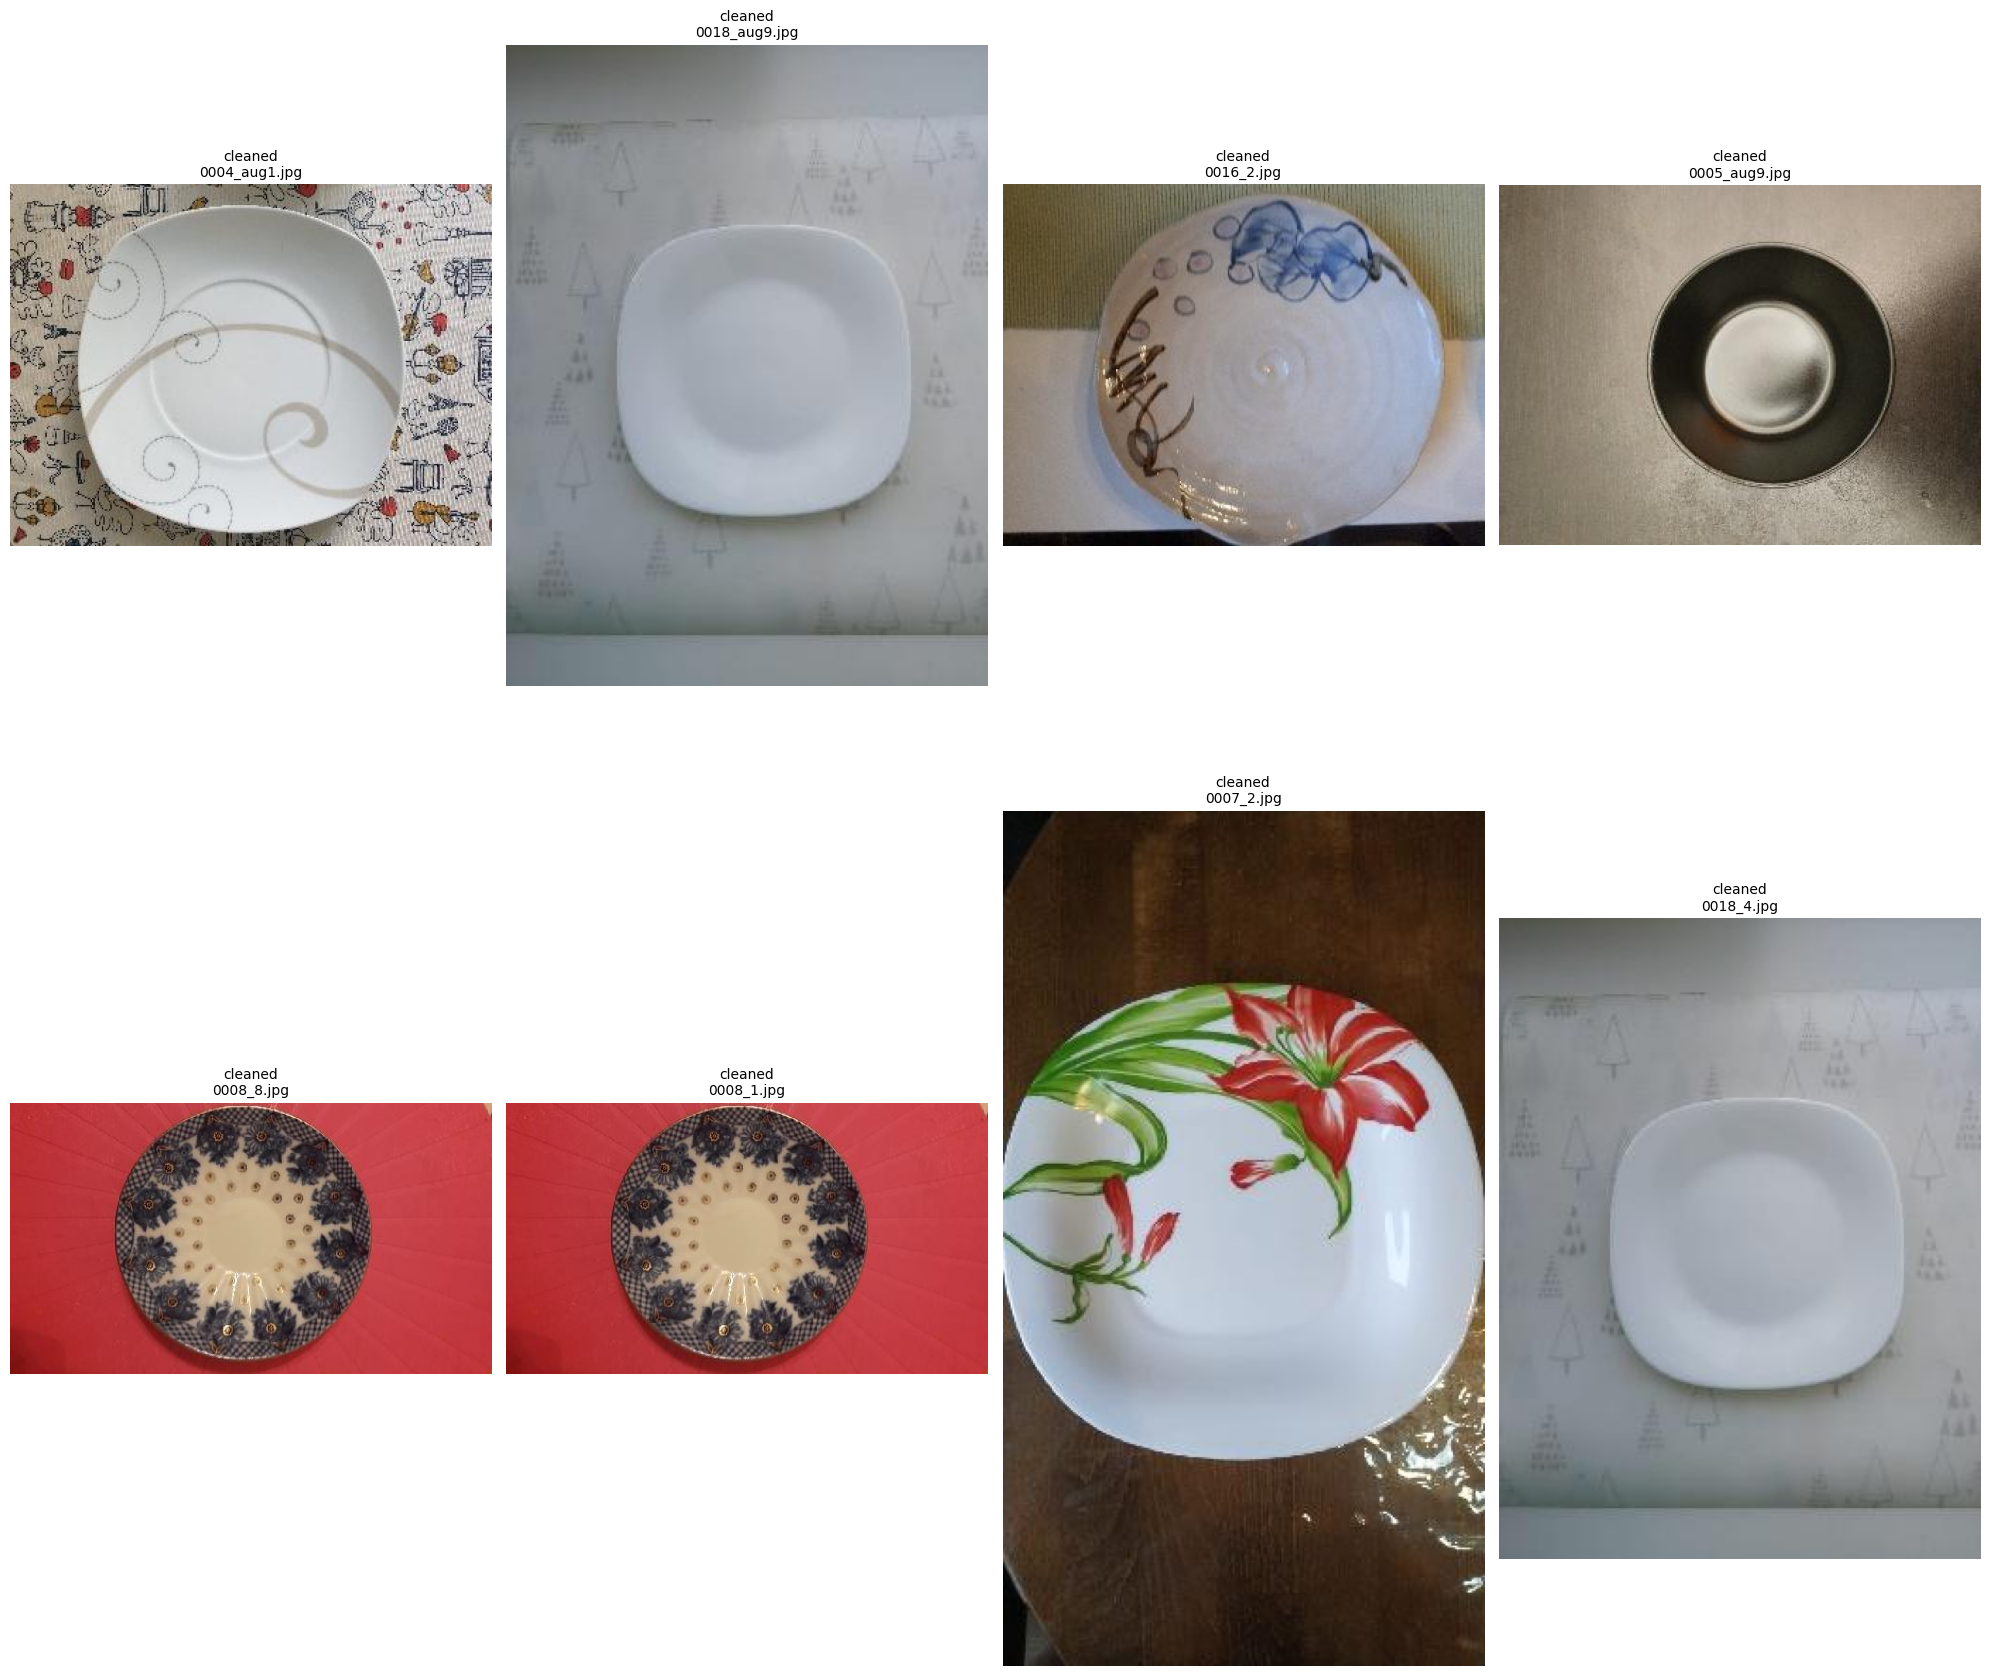


Визуализация аугментированных изображений: dirty


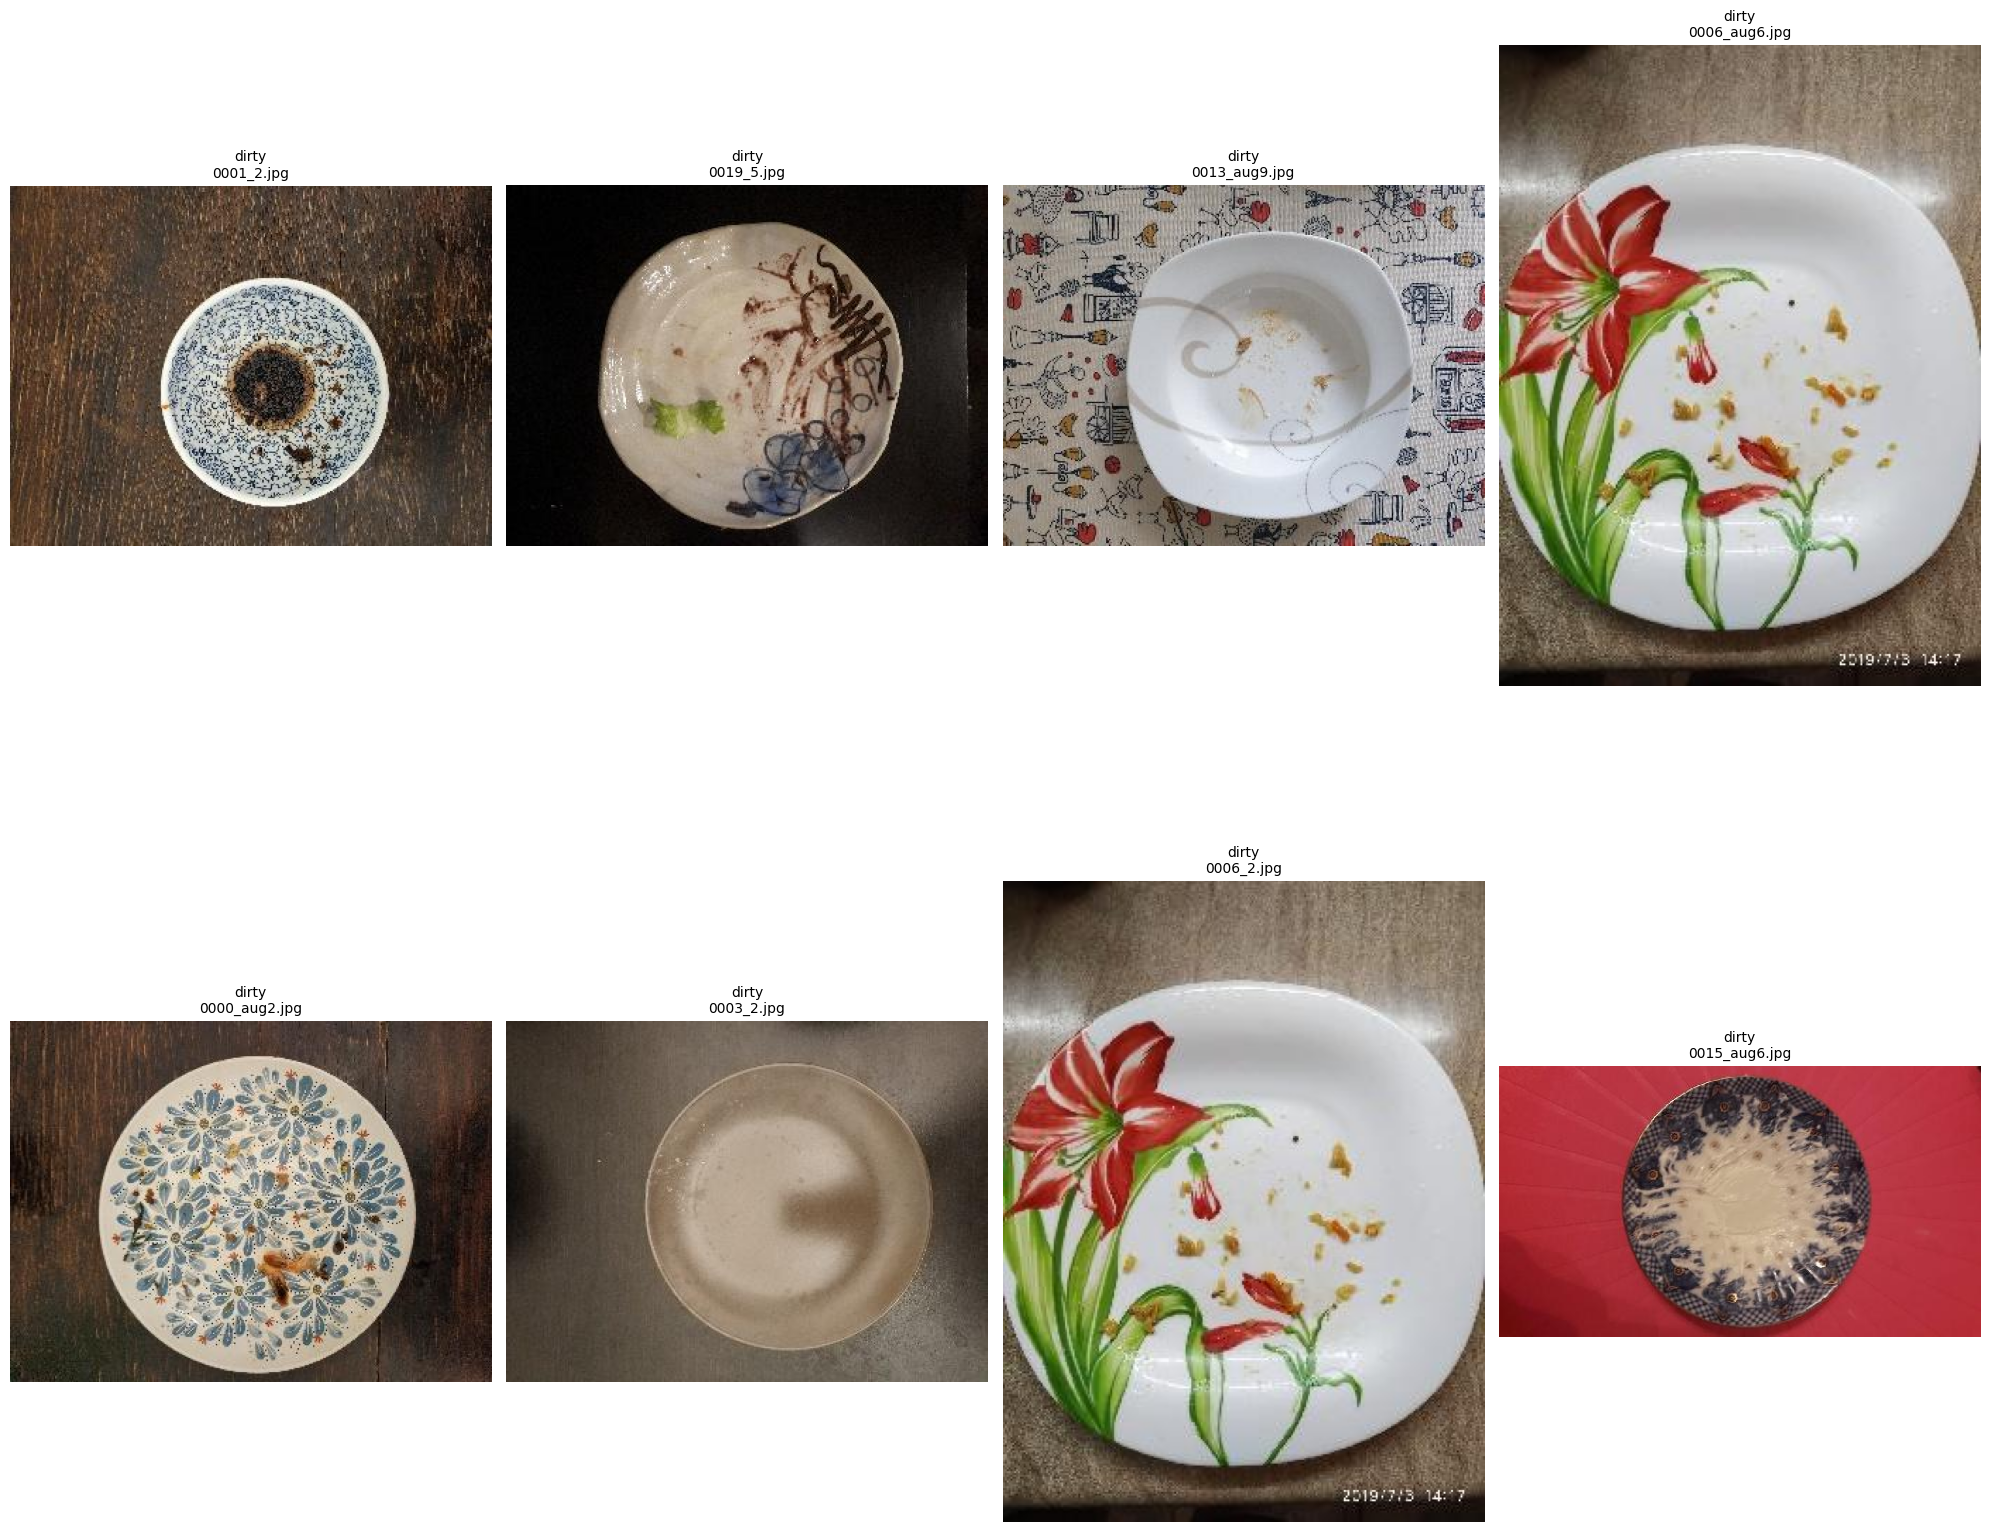

In [ ]:
def show_augmented_samples(label, samples_to_show=8):
    """Визуализация аугментированных изображений"""
    path = os.path.join(PATH_TO_AUG, label)

    if not os.path.exists(path):
        print(f"Папка {path} не существует!")
        return

    images = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]

    if not images:
        print(f"В папке {path} нет изображений!")
        return

    # Выбираем случайные образцы для показа
    if len(images) > samples_to_show:
        images = sample(images, samples_to_show)

    # Создаем сетку для отображения
    plt.figure(figsize=(20, 20))
    cols = 4  # Количество колонок
    rows = (len(images) + cols - 1) // cols  # Правильный расчет строк

    for i, img_name in enumerate(images):
        plt.subplot(rows, cols, i+1)
        img_path = os.path.join(path, img_name)
        try:
            img = PIL.Image.open(img_path)
            plt.imshow(img)
            plt.title(f"{label}\n{img_name}", fontsize=10)
            plt.axis('off')
        except Exception as e:
            print(f"Ошибка загрузки {img_path}: {str(e)}")

    plt.tight_layout()
    plt.show()

for label in labels:
    print(f"\nВизуализация аугментированных изображений: {label}")
    show_augmented_samples(label)